[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lwdovico/synthmob/reims-colab-demo.ipynb)

In [ ]:
from google.colab import drive
try:
  drive.mount('/content/drive')
except:
  print('Google drive was not mounted')
  !mkdir /content/drive

Mounted at /content/drive


In [ ]:
%%capture cap --no-stderr
#@markdown # Install Dependencies

!pip install synthmob

In [ ]:
city_name = 'Reims' #@param {type:"string"}
metric_projection = 'EPSG:27563' #@param {type:"string"}
timezone = 'Europe/Paris' #@param {type:"string"}

In [ ]:
# # check if timezone exists
assert timezone in __import__('pytz').all_timezones, "Set correct Timezone"

# IMPORT THE AOI

But for better customization I suggest using geojson.io

In [ ]:
%%capture cap --no-stderr
%cd /content/synthmob

import geomob
from synthmob.utils import get_and_save_bbox

AOI = f'aoi_{city_name}.geojson'

# retrieve the data (according to OSM api policy, you should provide your email)
city_shape = geomob.retrieve_osm(city_name, "SynthGPS Downloader (yourmailhere)").loc[[0]]
get_and_save_bbox(city_shape, AOI)

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))


In [16]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# geomob.plot_gdf(city_shape)

# GET DATA FROM OVERTURE AND GOOGLE EE

Here a Spark Session will be set.
If you have less cores reduce them to the appropriate amount to avoid freezing.

Google Earth Engine will be used to provide the rasters of the building height and population.

In [ ]:
from synthmob.utils import load_resources, get_tiles_wph
import numpy as np

OVERTURE = 'overture_s3_urls.json'

resources = load_resources(n_cores=1, aoi_path=AOI, resources_path=OVERTURE)
pv, rv, bv, aoi = resources['POIS'], resources['ROADS'], resources['BUILDINGS'], resources['AOI']
bbox_tess = get_tiles_wph('ee-ludovicolemma', aoi, metric_projection)

100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
/usr/local/lib/python3.10/dist-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [ ]:
pv.to_parquet('/content/drive/MyDrive/Synth/pv.parquet')
rv.to_parquet('/content/drive/MyDrive/Synth/rv.parquet')
bv.to_parquet('/content/drive/MyDrive/Synth/bv.parquet')
bbox_tess.to_parquet('/content/drive/MyDrive/Synth/bbox_tess.parquet')

# PROCESS ROADS

In [ ]:
from synthmob.roads import RoadProcessor

roads_pipeline = RoadProcessor(rv, metric_projection)

rv = roads_pipeline.roads
G = roads_pipeline.get_graph()

/content/synthmob/synth_gps/roads.py:70: FutureWarning: The `strict` parameter has been deprecated and will be removed in the v2.0.0 release. Use the `edge_attrs_differ` parameter instead to relax simplification strictness. For example, `edge_attrs_differ=None` reproduces the old `strict=True` behvavior and `edge_attrs_differ=['osmid']` reproduces the old `strict=False` behavior. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return simplify_graph(nx_graph.to_directed(), strict = False).to_undirected()


# [HIGHLY SUGGESTED]
If you don't know what you are doing: Run this.


If you know what you are doing you can just provide the Home Locations (Origins), Buildings and POIs (Destinations) yourself.
The requirements are that home locations have a "geometry" and "uid" column, and POIs have a "geometry" and "importance" column, both geometry column must be points, at the moment the buildings must be used anyway for generating static pings, it may change though.

## PROCESS BUILDINGS

 23%|██▎       | 14776/63762 [07:03<27:36, 29.57it/s]/usr/local/lib/python3.10/dist-packages/geomob/tessellate.py:121: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shape = base_shape.to_crs(project_on_crs).unary_union
 27%|██▋       | 17416/63762 [08:17<21:58, 35.15it/s]/usr/local/lib/python3.10/dist-packages/geomob/tessellate.py:121: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shape = base_shape.to_crs(project_on_crs).unary_union


<Axes: >

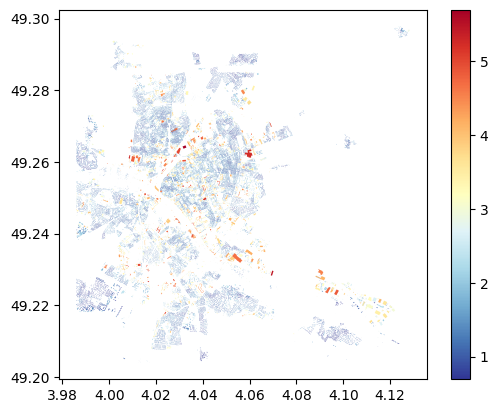

In [ ]:
from synthmob.building import BuildingProcessor, point_filling_geometries
from synthmob.metadata import generate_uids

bv_inhabitants = BuildingProcessor(bv, metric_projection).get_default_features(bbox_tess)
home_locations = point_filling_geometries(bv_inhabitants, n_point_feature = 'inhabitants')
home_locations['uid'] = generate_uids(len(home_locations))

bv_inhabitants.assign(log_inhabitants = np.log(bv_inhabitants['inhabitants'] + 1))\
              .plot('log_inhabitants', cmap = 'RdYlBu_r', legend = True)

## PROCESS POIs

The criterion used to determine the importance is the "centrality of the POI". I may change it in the future since it has some problems.

In [ ]:
from synthmob.pois import POIsProcessor

poi_pipeline = POIsProcessor(pv, metric_projection)
poi_pipeline.add_building_area(bv)

poi_pipeline.get_poi_centrality()
poi_pipeline.get_poi_importance()

poi_igraph = poi_pipeline.poi_igraph
edge_geoms = poi_pipeline.edge_geoms
pv_processed = poi_pipeline.pois

print(len(poi_igraph.components()), 'components')
print(len(edge_geoms), 'edges')

17 components
16850 edges


Text(0.5, 1.0, 'POIs centrality')

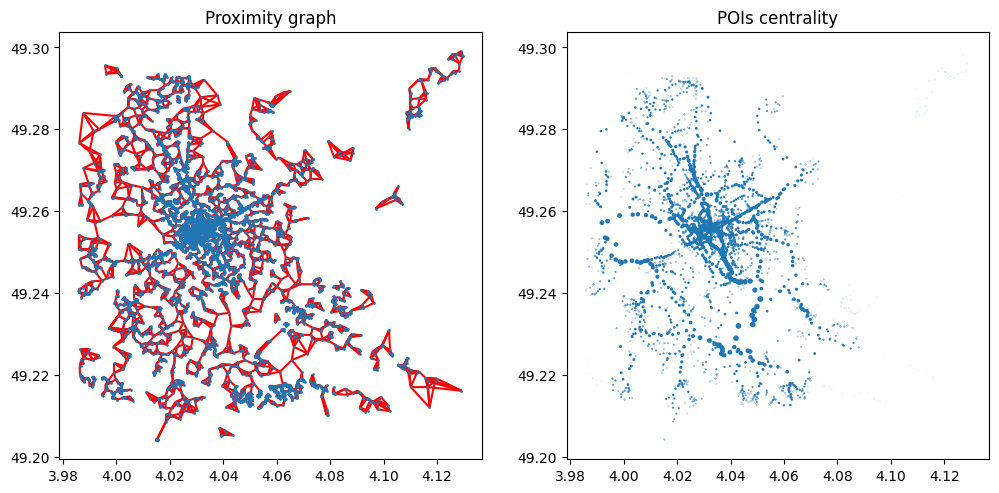

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

edge_geoms.plot(ax = axs[0], zorder = 1, color='red')
pv_processed.plot(markersize=1, ax = axs[0], zorder = 2)
axs[0].set_title('Proximity graph')
pv_processed.plot(markersize=pv_processed['centrality'] * 10 / pv_processed['centrality'].max(), ax = axs[1])
axs[1].set_title('POIs centrality')

# COMPUTE OD

In [ ]:
from synthmob.od import odGenerator
import geopandas as gpd

home_locations_reprojected = home_locations.to_crs(metric_projection)
pv_reprojected = pv_processed.to_crs(metric_projection)
road_nodes = gpd.GeoDataFrame(geometry = G.vs['geometry'], crs = metric_projection)

# in many large cities it is necessary to sample the OD pairs to avoid using too much memory
od_gen = odGenerator(home_locations_reprojected, pv_reprojected, road_nodes)

for _ in range(1):
    od_gen.generate_OD_pairs(kind = 'origins')

computational_OD = od_gen.get_computable_OD(which_destination='all')
computed_paths = od_gen.get_paths(G, computational_OD)
trips = od_gen.assign_paths_to_OD(od_gen.od_pairs, computed_paths)
trips['uid'] = trips.index.map(dict(enumerate(od_gen.uids)))

# VISUALIZE TRIPS

In [ ]:
agg_trips = od_gen.get_trips_with_size(which_destination = 'D', compute_space = True) # just for visualization
agg_trips.to_csv(f'/content/drive/MyDrive/Synth/{city_name}_trips.csv', index = False)

In [15]:
# geomob.plot_gdf(agg_trips.sample(frac = 0.1))

# ASSIGN OCCUPANCY TO ROADS

In [ ]:
occupancy_dict = dict(zip(*np.unique(np.concatenate(trips['edge'].values), return_counts=True)))
rv['occupancy'] = rv.index.map(occupancy_dict).fillna(0).astype(int)

# SETTING PARAMETERS

In [ ]:
from synthmob.metadata import SynthGPS

meters_road_buffer = 5
max_pings_per_user = 100
max_days = 1 # Use one to get only one day of data (better to control seasonality and creating a more diverse output)
hour_range = (0, 24)

synthetic_generator = SynthGPS(rv, meters_road_buffer, metric_projection, max_pings_per_user)
h_asset, w_asset, p_asset = synthetic_generator.generate_raw_static_assets(trips, road_nodes, home_locations, bv, pv)

100%|██████████| 218177/218177 [06:39<00:00, 546.75it/s]


# COMPUTING PINGS

The synthetic GPS data generator proceeds first by generating random points on buildings and roads.
Then it assigns the points by fitting lines according to the user paths and the user expected ping density.

Every random distribution used is approximately a power-law.
Thus the output is similar to what someone can expect from a real dataset.

Reduce the AOI size or the pings per user to speed up the computation.

It executes for the requested number of days, but I did not set any seasonality yet, so the synthetic days are just randomized variations of the typical one. Seasonality may be inserted by changing the max pings per user across the iterations.

nb. I may optimize or enrich it in the future

In [ ]:
import pandas as pd
from synthmob.metadata import get_midnight

get_data_for_days = 5  #@param

day = get_midnight()
days = {day + i * 24 * 60 * 60 : pd.DataFrame() for i in range(get_data_for_days)}

for i, day in enumerate(days):
     if days[day].empty:

          synthetic_generator.set_time(max_days, hour_range, timezone, day)
          generated_forward = synthetic_generator.generate_moving_pings(trips,
                                                                      noise_strength = 100, filter_speed = 200)

          generate_backward = synthetic_generator.generate_moving_pings(trips.assign(edge = trips['edge'].apply(lambda x: x[::-1]))\
                                                                           .rename(columns = {'O' : 'D', 'D' : 'O'}),
                                                                      noise_strength = 100, filter_speed = 200)

          moving = pd.concat([generated_forward, generate_backward],
                              ignore_index = True).sort_values('timestamp')\
                                                  .reset_index(drop = True)

          hs, ws, ps = synthetic_generator.generate_static_pings(moving['uid'].unique(),
                                                                 h_asset, w_asset, p_asset,
                                                                 homes_ratio = 0.30, workplaces_ratio = 0.25, pois_ratio = 0.25,
                                                                 home_hour_range = (20, 4), work_hour_range = (4, 20), poi_hour_range = (4, 20),
                                                                 noise_strength = 100)

          day_synthetic_dataset = pd.concat([moving, hs, ws, ps], ignore_index = True)\
                                    .sort_values('timestamp')[['uid', 'timestamp', 'geometry']]
          day_synthetic_dataset = day_synthetic_dataset[day_synthetic_dataset['timestamp'] < day + 24 * 60 * 60].copy(deep = True)

          day_synthetic_dataset['lat'] = day_synthetic_dataset['geometry'].apply(lambda x: x.y)
          day_synthetic_dataset['lng'] = day_synthetic_dataset['geometry'].apply(lambda x: x.x)
          day_synthetic_dataset['timestamp'] = day_synthetic_dataset['timestamp'].astype(int)
          day_synthetic_dataset = day_synthetic_dataset.drop('geometry', axis = 1)

          days[day] = day_synthetic_dataset

full_dataset_synthetic = pd.concat(days.values(), ignore_index = True)
full_dataset_synthetic.to_csv(f'/content/drive/MyDrive/Synth/{city_name}_pings.csv', index = False)

In [ ]:
len(full_dataset_synthetic)

2879774

In [14]:
# geomob.plot_gdf(full_dataset_synthetic.sample(frac=0.5))